In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
plt.rc('font', family='NanumGothicOTF') # For MacOS
print(plt.rcParams['font.family'])

['NanumGothicOTF']


# 감정 분류

In [2]:
df = pd.read_csv("MM_data2.csv")


In [3]:
df.columns

Index(['script', 'txt_emotion', 'txt_valence', 'txt_arousal', 'sound_emotion',
       'sound_valence', 'sound_arousal', 'morpheme'],
      dtype='object')

In [4]:
df = df[["script", "txt_emotion"]]

In [5]:
df.txt_emotion.value_counts()

neutral     28381
fear        11162
happy        9833
sad          8830
dislike      6965
surprise     5352
angry        4126
contempt     1892
Name: txt_emotion, dtype: int64

In [6]:
# angry disgusting fearful happy sad surprising neutral

In [7]:
df["txt_emotion"][df["txt_emotion"] == "neutral"] = 0

df["txt_emotion"][df["txt_emotion"] == "fear"] = 1

df["txt_emotion"][df["txt_emotion"] == "surprise"] = 2

df["txt_emotion"][df["txt_emotion"] == "contempt"] = 3
df["txt_emotion"][df["txt_emotion"] == "dislike"] = 3

df["txt_emotion"][df["txt_emotion"] == "happy"] = 4

df["txt_emotion"][df["txt_emotion"] == "sad"] = 5

df["txt_emotion"][df["txt_emotion"] == "angry"] = 6

In [8]:
df.txt_emotion.value_counts()

0    28381
1    11162
4     9833
3     8857
5     8830
2     5352
6     4126
Name: txt_emotion, dtype: int64

In [9]:
train_data, test_data = train_test_split(df, test_size = 0.35)

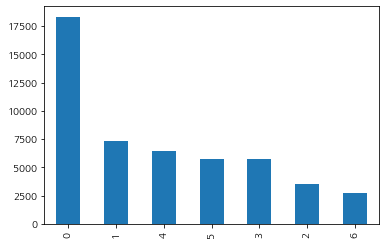

In [10]:
train_data['txt_emotion'].value_counts().plot(kind = 'bar')

In [11]:
print(train_data.groupby('txt_emotion').size().reset_index(name = 'count'))

   txt_emotion  count
0            0  18325
1            1   7296
2            2   3512
3            3   5731
4            4   6435
5            5   5750
6            6   2702


In [12]:
train_data.isnull().sum()

script         0
txt_emotion    0
dtype: int64

In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['script'] = train_data['script'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,script,txt_emotion
39186,아니야 내가 잘 기억하면 되지,4
55431,응 우리 아저씨도 이번 주말에는 어디 안 간다네,0
14522,좀그렇다니 그게무슨말이야,1
2824,네 뭐 잘 지냈습니다,0
68626,엄마 주말에 오잖아 삼일 지나면 오지,0


In [14]:
train_data['script'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

script         2
txt_emotion    0
dtype: int64


In [15]:
# 결측치 제거
train_data.loc[train_data.script.isnull()]
train_data = train_data.dropna(how = 'any')
print(len(train_data))

49749


In [16]:
# 테스트 데이터 전처리
test_data.drop_duplicates(subset = ['script'], inplace=True) # script 열에서 중복인 내용이 있다면 중복 제거
test_data['script'] = test_data['script'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['script'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 26788


In [17]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [18]:
okt = Okt()

In [19]:
X_train = []
for script in train_data['script']:
    temp_X = []
    temp_X = okt.morphs(script, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [20]:
print(X_train[:3])
print(len(X_train))

[['아니다', '내', '자다', '기억', '되다'], ['응', '우리', '아저씨', '이번', '주말', '에는', '어디', '안', '간다', '네'], ['그렇다', '그게', '무슨', '말', '이야']]
49749


In [21]:
X_test = []
for script in test_data['script']:
    temp_X = []
    temp_X = okt.morphs(script, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [22]:
print(X_test[:3])
print(len(X_test))

[['나', '인터넷', '들어가다', '보고', '싶다', '거', '있다'], ['번', '물어보다'], ['뭐', '야', '너', '무슨', '연애', '전문가', '야', '뭐', '야']]
26788


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [24]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14601
등장 빈도가 2번 이하인 희귀 단어의 수: 7683
단어 집합에서 희귀 단어의 비율: 52.61968358331621
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.4531485790322702


In [25]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 6920


In [26]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [27]:
len(X_train)

49749

In [28]:
len(X_test)

26788

In [29]:
y_train = np.array(train_data['txt_emotion'])
y_test = np.array(test_data['txt_emotion'])

In [30]:
# 빈 샘플 제거
drop_train = [index for index, script in enumerate(X_train) if len(script) < 1]
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

49728
49728


In [31]:
y_train

array([4, 0, 1, ..., 3, 0, 4], dtype=object)

리뷰의 최대 길이 : 71
리뷰의 평균 길이 : 8.115407818532818


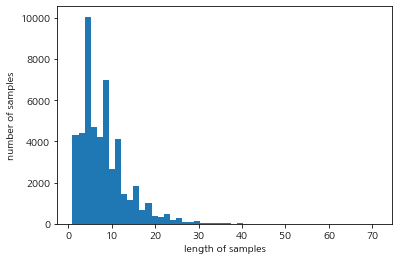

In [32]:
# 패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [33]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [34]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 99.48519948519949


In [35]:
# 패딩 길이를 30으로 맞춤
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [36]:
X_train

array([[   0,    0,    0, ...,   30,  282,   17],
       [   0,    0,    0, ...,    5,  630,   19],
       [   0,    0,    0, ...,   52,   15,   53],
       ...,
       [   0,    0,    0, ...,   12, 1423,  105],
       [   0,    0,    0, ..., 4197,  114,  162],
       [   0,    0,    0, ...,   33,  183,   70]], dtype=int32)

In [37]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [38]:
y_train = to_categorical(y_train) # 훈련용 레이블의 원-핫 인코딩
y_test = to_categorical(y_test) # 테스트용 레이블의 원-핫 인코딩

In [39]:
len(y_train)

49728

In [40]:
len(X_train)

49728

In [41]:
len(X_test)

26788

In [42]:
len(y_test)

26788

# LSTM

In [43]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(7, activation='softmax'))

# CNN

In [44]:
# from keras.datasets import reuters
# from keras.utils import np_utils
# from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM
# from keras.layers import Flatten, Dropout
# from keras.layers import Conv1D, GlobalMaxPooling1D

# max_features = 15000
# text_max_words = 120

# model = Sequential()
# model.add(Embedding(vocab_size, 128, input_length=text_max_words))
# model.add(Dropout(0.2))
# model.add(Conv1D(256,
#                  3,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(5, activation='softmax'))

# CNN - LSTM

In [45]:
# from keras.datasets import reuters
# from keras.utils import np_utils
# from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import Dense, Embedding, LSTM
# from keras.layers import Flatten, Dropout
# from keras.layers import Conv1D, MaxPooling1D

# model = Sequential()
# model.add(Embedding(vocab_size, 128, input_length=text_max_words))
# model.add(Dropout(0.2))
# model.add(Conv1D(256,
#                  3,
#                  padding='valid',
#                  activation='relu',
#                  strides=1))
# model.add(MaxPooling1D(pool_size=4))
# model.add(LSTM(128))
# model.add(Dense(5, activation='softmax'))

In [46]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [48]:
history = model.fit(X_train, y_train, batch_size=64, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
777/777 [==============================] - ETA: 0s - loss: 1.5537 - acc: 0.4326
Epoch 00001: val_acc improved from -inf to 0.46812, saving model to best_model.h5
777/777 [==============================] - 27s 35ms/step - loss: 1.5537 - acc: 0.4326 - val_loss: 1.4521 - val_acc: 0.4681
Epoch 2/30
776/777 [============================>.] - ETA: 0s - loss: 1.3471 - acc: 0.5077
Epoch 00002: val_acc improved from 0.46812 to 0.47514, saving model to best_model.h5
777/777 [==============================] - 29s 37ms/step - loss: 1.3471 - acc: 0.5077 - val_loss: 1.4393 - val_acc: 0.4751
Epoch 3/30
777/777 [==============================] - ETA: 0s - loss: 1.2505 - acc: 0.5428
Epoch 00003: val_acc did not improve from 0.47514
777/777 [==============================] - 23s 30ms/step - loss: 1.2505 - acc: 0.5428 - val_loss: 1.4540 - val_acc: 0.4702
Epoch 4/30
777/777 [==============================] - ETA: 0s - loss: 1.1802 - acc: 0.5693
Epoch 00004: val_acc did not improve from 0.47514


In [49]:
model.save("Multimodal_affect_model.h5")

In [50]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

838/838 [==============================] - 5s 6ms/step - loss: 1.6263 - acc: 0.4521

 테스트 정확도: 0.4521


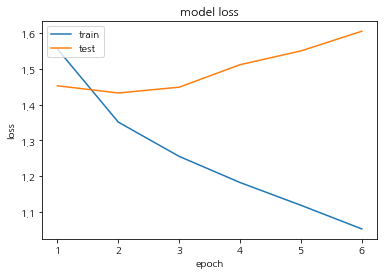

In [55]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
def sentiment_predict(new_script):
    new_script = okt.morphs(new_script, stem=True) # 토큰화
    new_script = [word for word in new_script if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_script]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = np.array(loaded_model.predict(pad_new)) # 예측
    result = ""
    if score.argmax() == 0:
        result = "중립"
    elif score.argmax() == 1:
        result = "공포"
    elif score.argmax() == 2:
        result = "놀람"
    elif score.argmax() == 3:
        result = "혐오"
    elif score.argmax() == 4:
        result = "행복"
    elif score.argmax() == 5:
        result = "슬픔"
    elif score.argmax() == 6:
        result = "분노"
    return result

In [1]:
# def sentiment_predict(new_script):
#     new_script = okt.morphs(new_script, stem=True) # 토큰화
#     new_script = [word for word in new_script if not word in stopwords] # 불용어 제거
#     encoded = tokenizer.texts_to_sequences([new_script]) # 정수 인코딩
#     pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
#     score = np.array(loaded_model.predict(pad_new)) # 예측
#     result = ""
#     if score.argmax() == 0:
#         result = "중립"
#     elif score.argmax() == 1:
#         result = "공포"
#     elif score.argmax() == 2:
#         result = "행복"
#     elif score.argmax() == 3:
#         result = "슬픔"
#     elif score.argmax() == 4:
#         result = "반감"
#     elif score.argmax() == 5:
#         result = "놀람"
#     elif score.argmax() == 6:
#         result = "분노"
#     elif score.argmax() == 7:
#         result = "경멸"
#     return result

In [58]:
sentiment_predict('오늘 남자친구랑 헤어졌어 죽고싶어')

'슬픔'

In [75]:
sentiment_predict('지금 기분이 너무 좋아')

'행복'

In [77]:
sentiment_predict('완전 행복해')

'행복'

In [87]:
sentiment_predict('넌 딱 45짜리야')

'분노'

# 오디오 불러오기 & 처리

In [63]:
from pydub import AudioSegment

test_file = AudioSegment.from_mp3("anger.mp3")
type(test_file)

pydub.audio_segment.AudioSegment

In [64]:
test_file.export(out_f="test_file.wav", format="wav")

<_io.BufferedRandom name='test_file.wav'>

In [65]:
import speech_recognition as sr

recognizer = sr.Recognizer()
recognizer.energy_threshold = 300

In [66]:
corona_audio = sr.AudioFile("test_file.wav")

with corona_audio as source:
    corona = recognizer.record(source)

text = recognizer.recognize_google(audio_data=corona, language="ko-KR")
text

'윤다 분노조절장애란 범죄가 끊이지 않고 있습니다 별것 아닌 일에도 극단적인 분노를 나타내고 결국 폭행과 범죄로 이어지는 이런 일이 왜 계속 놀고 있는 것인지 우종은 기자가 취재했습니다 접촉사고에 항의하는 자동차 운전자에게 느닷없이 동기를 덥지는 자전거 운전자 별 것 아닌 일에도 불같이 분노를 쏟아낸이 남성을 경찰이 잡고보니 분노조절 질환을 앓고 있었던 것으로 드러났습니다 경찰에 구속된 41살 서모씨는 지난 10년 동안 약물복용에 왔던 것으로 전해졌습니다 아버지를 상습적으로 때려 부러뜨리고 아령까지 동원의 폭행한 혐의로 구속된 21살 방문 시도 분노조절장애 환자였습니다 이처럼 스스로 충동을 제거하지 못하는 분노조절장애로 병원을 찾는 이들이 해마다 늘고 있습니다 2010년부터 지난해까지 충동장애로 병원을 찾은 일은 1600여명이 들었습니다 광주지역은 같은 기간 191명에서 324명으로 약 70% 나 증가했습니다 이른바 무시당했다는데 욱해서 벌어지는 이같은 범죄 와 관련해 전문가들인 성취지향적인 우리 사회 분위기가 개인들을 좌절감에 빠트린 것이 한몫한 것으로 보고 있습니다 약물치료 함께 걷던 충동조절이라고 하는 것이 어느 정도 조절되고 관리가 된 상태라고 하면 심리 치료를 통해서 어떻게 내 감정을 인식하고 또 안전한 방식으로 표현할 수 있는지에 대해서 훈련하시는 것도 필요할 것 같고요 언제 어디서 느닷없이 공격해 들어올지 모르는 분노조절장애 범죄가 불안한들을 더 힘들게 하고 있습니다 MBC 뉴스 구조물입니다'

In [68]:
sentiment_predict(text)

'행복'